# Likelihood Analysis with fermipy

The python likelihood tools are a very powerful set of analysis tools that expand upon the command line tools provided with the Fermi Science Tools package. Not only can you perform all of the same likelihood analysis with the python tools that you can with the standard command line tools but you can directly access all of the model parameters. You can more easily script a standard analysis. There are also a few things built into the python tools that are not available from the command line like the calculation of upper limits.

There are many user contributed packages built upon the python backbone of the Science Tools and this thread will highlight the use of the [fermipy](http://fermipy.readthedocs.org) package.

This sample analysis of RX J1713.7-3946 is based on the PG 1553+113 analysis performed by the LAT team and described in [Abdo, A. A. et al. 2010, ApJ, 708, 1310](http://adsabs.harvard.edu/abs/2010ApJ...708.1310A) and closely follows the [Likelihood Analysis with Python](http://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/python_tutorial.html) thread.  This tutorial assumes you have the most recent ScienceTools installed and [fermipy](http://fermipy.readthedocs.org) installed on top of it.  For instructions on installing fermipy and the Fermi ScienceTools you should consult the [fermipy Installation Instructions](http://fermipy.readthedocs.org/en/latest/install.html).  We will also make significant use of python, so you might want to familiarize yourself with python including matplotlib and other libraries (there's a beginner's guide at http://wiki.python.org/moin/BeginnersGuide). This tutorial also assumes that you've gone through the non-python based [Unbinned Likelihood Tutorial](http://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/likelihood_tutorial.html).  

## Get the Data

For this thread the original data were extracted from the [LAT data server](http://fermi.gsfc.nasa.gov/cgi-bin/ssc/LAT/LATDataQuery.cgi) with the following selections (these selections are similar to those in the 4FGL-DR4 paper):

* Search Center (RA,Dec) = (258.112,-39.687)
* Radius = 15 degrees
* Start Time (MET) = 239557417 seconds (2008-08-04T15:43:36)
* Stop Time (MET) = 681169985 seconds (2022-08-02T21:53:00)
* Minimum Energy = 50 MeV
* Maximum Energy = 1000000 MeV

Let's retrieve the data.  In this example the output of the analysis will go into a subdirectory called *data*.

In [8]:
import os
import gdown

if os.path.isdir('data'):
    os.environ['DATA_DIR'] = 'data'
else:
    os.mkdir('data')
    os.environ['DATA_DIR'] = 'data'

drive_file_IDs = [
["1B435l5DwDWoaKOq88Ljy7rBmcW_T9dD2","data/L230831165314B24E85D632_SC00.fits"],
["1AVK4mR-KfC0R4Be8bQ8paf1LPEi4fa9P","data/L230831165314B24E85D632_PH00.fits"],
["1AylrtavbJMaGADh-bEJ6y9Z35d-q-hFk","data/L230831165314B24E85D632_PH01.fits"],
["1B6Ogp9qA9Yb1TZ-AnqSIam3CEsccSFOC","data/L230831165314B24E85D632_PH02.fits"],
["1B-1OGD9GtMK-_98AmNz-To7njJqzlUN8","data/L230831165314B24E85D632_PH03.fits"],
["1B8LKOot0ZKER2J5FaEFAK6fGM1k2FZU8","data/L230831165314B24E85D632_PH04.fits"],
["1B0iCHiwtRvjdd9W-9HWB0B0Y6Okz5SC3","data/L230831165314B24E85D632_PH05.fits"],
["1gvmxLRniF_sCIRIpCpieFWVja_gfvUbL","data/ltcube_00.fits"]
]
for file in drive_file_IDs :
    if not os.path.isfile(file[1]):
       gdown.download(id=file[0],output=file[1],quiet=False)


Now let's retrieve the diffuse emission models. These come directly from the *fermipy-extras* package. We will put them in the *diffuse* subdirectory.

In [9]:

if os.path.isfile('diffuse.tar.gz'):
    !tar xzf diffuse.tar.gz
else:
    !curl -OL https://raw.githubusercontent.com/fermiPy/fermipy-extras/master/data/diffuse.tar.gz
    !tar xzf diffuse.tar.gz

### Make a file list

You'll then need to make a file list with the names of your input event files. You can either just make one with a text editor or do the following from the command line.

In [10]:
!ls -1 data/*PH*.fits > data/RXJ1713.7-3946.lst

## Make a config file

fermipy bases its analysis on a configuration file (in [yaml](http://yaml.org) format).  We're just going to use a really simple config file for a standard analysis.  There are many many more options which you can use or you can modify these options after the fact within the analysis chain.


Make a config file named 'config.yaml' like the following.  For more details on the config file see [config.html](http://fermipy.readthedocs.org/en/latest/config.html).  You will probably need to customize this a bit since your files might not be in the same place or named the same.  The galactic and isotropic diffuse will need to be located on your system (they are included in the science tools or can be downloaded from the FSSC).  In the following example we set the path to these files with the environment variable FERMI_DIFFUSE_DIR.  If FERMI_DIFFUSE_DIR is not defined fermipy will look for the location of these files within the FSSC STs distribution. 

```
data:
  evfile : RXJ1713.7-3946.lst
  scfile : L211025154921445A2D9929_SC00.fits
  ltcube : ltcube_00.fits

binning:
  roiwidth   : 10.0
  binsz      : 0.1
  binsperdec : 8

selection :
  emin : 100
  emax : 300000
  tmin : 239557417
  tmax : 681169985
  zmax    : 90
  evclass : 128
  evtype  : 3
  target : 'RXJ1713.7-3946'

gtlike:
  edisp : True
  irfs : 'P8R2_SOURCE_V6'
  edisp_disable : ['isodiff','galdiff']

model:
  src_roiwidth : 15.0
  galdiff  : 'diffuse/gll_iem_v07.fits'
  isodiff  : 'diffuse/iso_P8R2_SOURCE_V6_v06.txt'
  catalogs : ['4FGL']
```

## Start the analysis

Next, you create an analysis script and run the setup steps which include running the selections and generating exposure maps etc.  This will take a bit.

This is where the magic happens.  fermipy will load the point source model, create your xml file for you, decide on all the appropriate cuts and binnings and just go.  All of this is configurable from python or from the config file.  And, if you need to rerun things, it's smart enough to not overwrite files if it doesn't need to.

### Load up some useful modules

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

### Import the GTAnalysis module from fermipy

You start by importing the module and then creating an instance of the analysis object from our config file.  When instantiating the analysis object we can override any options defined in the configuration file by passing keyword arguments to the object constructor.  Here we explicitly set the verbosity parameter to 3 (INFO) which supresses DEBUG output.  When we create the object, it spits out a bunch of information about all of the parameters that were used.  You can see there are many more options than the ones we chose.

In [53]:
from fermipy.gtanalysis import GTAnalysis
gta = GTAnalysis('data/config.yaml',logging={'verbosity': 3})
matplotlib.interactive(True)

2023-10-11 20:20:16 INFO    GTAnalysis.__init__(): 
--------------------------------------------------------------------------------
fermipy version 1.2.0 
ScienceTools version 2.2.0


### The setup routine

This gets everything ready for the likelihood analysis including instantiating the pylikelihood object.  Note that fermipy will skip generating any ancillary files that already exist in the working directory.  In the sample tarball these files have already been produced in order to speed up this stage of the analysis.  If you want to see the behavior of fermipy when running from an empty working directory you can delete one or more of these files before running *setup*.

In [ ]:
gta.setup()

2023-10-12 00:03:27 INFO    GTAnalysis.setup(): Running setup.
2023-10-12 00:03:27 INFO    GTBinnedAnalysis.setup(): Running setup for component 00
2023-10-12 00:03:27 INFO    GTBinnedAnalysis._select_data(): Skipping data selection.
2023-10-12 00:03:27 INFO    GTBinnedAnalysis._create_ltcube(): Skipping LT Cube.
2023-10-12 00:03:29 INFO    GTBinnedAnalysis._create_expcube(): Skipping gtexpcube.
2023-10-12 00:03:29 INFO    GTBinnedAnalysis.run_gtapp(): Running gtsrcmaps.
2023-10-12 00:03:29 INFO    GTBinnedAnalysis.run_gtapp(): time -p gtsrcmaps scfile=/raid0/home/chen/PHYS2015_2023/data/L230831165314B24E85D632_SC00.fits sctable="SC_DATA" expcube=/raid0/home/chen/PHYS2015_2023/data/ltcube_00.fits cmap=/raid0/home/chen/PHYS2015_2023/data/ccube_00.fits srcmdl=/raid0/home/chen/PHYS2015_2023/data/srcmdl_00.xml bexpmap=/raid0/home/chen/PHYS2015_2023/data/bexpmap_00.fits wmap=none outfile=/raid0/home/chen/PHYS2015_2023/data/srcmap_00.fits irfs="P8R2_SOURCE_V6" evtype=3 convol=yes resample=ye

Before proceeding with the analysis we'll have a quick look at the files that are produced by the setup function.

In [18]:
ls data/*.fits

data/4fgl_j1713.5-3945e_sed.fits        data/L230831165314B24E85D632_PH01.fits
data/bexpmap_00.fits                    data/L230831165314B24E85D632_PH02.fits
data/bexpmap_roi_00.fits                data/L230831165314B24E85D632_PH03.fits
data/ccube_00.fits                      data/L230831165314B24E85D632_PH04.fits
data/ccube.fits                         data/L230831165314B24E85D632_PH05.fits
data/fit0.fits                          data/L230831165314B24E85D632_SC00.fits
data/ft1_00.fits                        data/ltcube_00.fits
data/L230831165314B24E85D632_PH00.fits  data/srcmap_00.fits


Here is a brief explanation of the contents of each file and its role in the analysis:

* **ft1_00.fits**: Event list.  This is generated by running gtselect and gtmktime on our input file list.
* **bexpmap_00.fits**: All-sky binned exposure map.  This map is interpolated to create an exposure model when generating the srcmap file.
* **bexpmap_roi_00.fits**: Binned exposure map for the ROI.  This file is only provided for visualization purposes in order to have an exposure map with the same binning as the data and model maps.
* **ccube_00.fits**: Counts cube for the ROI.
* **ltcube_00.fits**: Livetime cube.  This contains a map of the livetime for this observation over the whole sky as a function of incidence angle.
* **srcmap_00.fits**: Source map cube.  This file contains maps for each of the components in the ROI after convolution with exposure and the PSF.  Note that energy dispersion is applied at run-time.

Note that all of the files have a numerical suffix '00'.  This is the analysis component index.  In a multi-component analysis there would be instances of all of the above files for each analysis component.  The files with no component index are co-added maps that are provided for visualization purposes.

To see example of one of these files we can open and plot the counts cube file.  This is a 3D cube that contains the distribution of events as a function of energy and two spatial coordinates.  In the example below we sum over the energy dimension of the cube to make a 2-D sky image.

Filename: data/ccube.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      28   (100, 100, 28)   float32   
  1  EBOUNDS       1 BinTableHDU     22   28R x 4C   [K, D, D, D]   


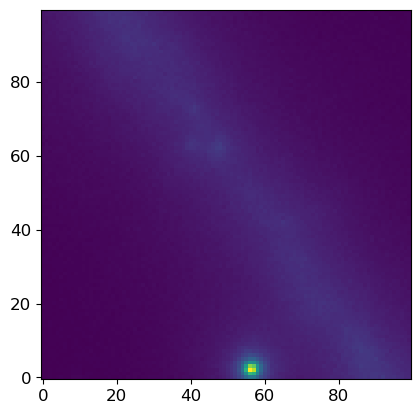

In [19]:
import astropy.io.fits as pyfits

h = pyfits.open('data/ccube.fits')
h.info()
counts = h[0].data
counts.shape
plt.figure()
plt.imshow(np.sum(counts,axis=0),interpolation='nearest',origin='lower')

We can now inspect the state of the ROI prior with the print_roi() method.

In [20]:
gta.print_roi()

2023-10-11 17:35:06 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
4FGL J1713.5-3945e  SpatialMap     LogParabola       0.000       nan      4851.4
4FGL J1710.3-3943   PointSource    LogParabola       0.613       nan     15368.7
4FGL J1715.4-4025   PointSource    PowerLaw          0.763       nan      5486.6
4FGL J1714.8-3849   PointSource    LogParabola       0.976       nan     12578.5
4FGL J1717.5-4022   PointSource    LogParabola       0.987       nan       458.4
4FGL J1714.4-3830   PointSource    PLSuperExpCuto    1.265       nan     43067.3
4FGL J1712.9-4105   PointSource    PowerLaw          1.340       nan       624.1
4FGL J1706.5-4023   PointSource    PowerLaw          1.475       nan     15165.4
4FGL J1714.1-3811   PointSource    PowerLaw          1.573       nan      3680.9
4FGL J1718.2-3825   PointSource    PLSuperExpCuto    1.6

Additional details about an individual source can be retrieved by printing the corresponding source object.  Here we use the bracket operator to return the properties of PKS 2155-403. 

In [21]:
source_name = '4FGL J1713.5-3945e'
print(gta.roi[source_name])

Name           : 4FGL J1713.5-3945e
Associations   : ['4FGL J1713.5-3945e', 'RX J1713.7-3946']
RA/DEC         :    258.390/   -39.760
GLON/GLAT      :    347.336/    -0.473
TS             : nan
Npred          : 4851.42
Flux           : 1.178e-08 +/-      nan
EnergyFlux     : 5.866e-05 +/-      nan
SpatialModel   : SpatialMap
SpectrumType   : LogParabola
Spectral Parameters
b'norm'        :  1.061e-13 +/-        nan
b'alpha'       :        1.6 +/-        nan
b'beta'        :    0.07365 +/-        nan
b'Eb'          :       8922 +/-        nan


In [22]:
print(gta.roi['4FGL J1730.1-4343'])

Name           : 4FGL J1730.1-4343
Associations   : ['4FGL J1730.1-4343']
RA/DEC         :    262.539/   -43.727
GLON/GLAT      :    345.818/    -5.270
TS             : nan
Npred          : 1825.84
Flux           : 6.728e-09 +/-      nan
EnergyFlux     : 3.002e-06 +/-      nan
SpatialModel   : PointSource
SpectrumType   : LogParabola
Spectral Parameters
b'norm'        :  1.488e-12 +/-        nan
b'alpha'       :      2.679 +/-        nan
b'beta'        :     0.7284 +/-        nan
b'Eb'          :      918.7 +/-        nan


## Do the likelihood fitting

Now that all of the ancillary files have been generated, we can move on to the actual fitting.  The first thing you should do is free some of the sources since all of the sources are initially fixed.  We'll just free those sources in the center region.

In [23]:
# Free Normalization of all Sources within 3 deg of ROI center
gta.free_sources(distance=3.0,pars='norm')

# Free all parameters of isotropic and galactic diffuse components
gta.free_source('galdiff')
gta.free_source('isodiff')

2023-10-11 17:35:20 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J1713.5-3945e    : ['norm']
2023-10-11 17:35:20 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J1710.3-3943     : ['norm']
2023-10-11 17:35:20 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J1715.4-4025     : ['Prefactor']
2023-10-11 17:35:20 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J1714.8-3849     : ['norm']
2023-10-11 17:35:20 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J1717.5-4022     : ['norm']
2023-10-11 17:35:20 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J1714.4-3830     : ['Prefactor']
2023-10-11 17:35:20 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J1712.9-4105     : ['Prefactor']
2023-10-11 17:35:20 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J1706.5-4023     : ['Prefactor']
2023-10-11 17:35:20 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J1714.1-3811     :

In this simple anlaysis we are leaving the spectral shapes of sources fixed but we're going to free the spectral shape of the source we care about.  

In [24]:
gta.free_source(source_name)

2023-10-11 17:35:26 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J1713.5-3945e    : ['alpha', 'beta']


Now, actually do the fit.  The software does its best to get the fit to converge by running the fit several times.

In [25]:
fit_results = gta.fit()

2023-10-11 17:35:31 INFO    GTAnalysis.fit(): Starting fit.
/raid0/home/chen/mambaforge/envs/fermipy/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
2023-10-11 17:37:24 INFO    GTAnalysis.fit(): Fit returned successfully. Quality:   2 Status: 102
2023-10-11 17:37:24 INFO    GTAnalysis.fit(): LogLike: 14058481.340 DeltaLogLike:    23028.498 


In [26]:
print('Fit Quality: ',fit_results['fit_quality'],', Fit status: ',fit_results['fit_status'])

Fit Quality:  2 , Fit status:  102


Comment on fit quality

In [27]:
fit_results = gta.fit()

2023-10-11 17:37:33 INFO    GTAnalysis.fit(): Starting fit.
2023-10-11 17:40:49 INFO    GTAnalysis.fit(): Fit returned successfully. Quality:   3 Status:   0
2023-10-11 17:40:49 INFO    GTAnalysis.fit(): LogLike: 14058481.355 DeltaLogLike:        0.014 


The dictionary returned by the fit method returns a variety of diagnostic information about the fit including the fit quality, the relative improvement in the likelihood, and the correlations among the fit parameters.  We can inspect the results of the fit by printing the source object for PG1553.

In [30]:
print('Fit Quality: ',fit_results['fit_quality'], 'Fit status: ',fit_results['fit_status'])
print(gta.roi[source_name])

Fit Quality:  3 Fit status:  0
Name           : 4FGL J1713.5-3945e
Associations   : ['4FGL J1713.5-3945e', 'RX J1713.7-3946']
RA/DEC         :    258.390/   -39.760
GLON/GLAT      :    347.336/    -0.473
TS             : 4969.49
Npred          : 37146.48
Flux           : 1.142e-07 +/- 4.73e-09
EnergyFlux     : 0.0001046 +/- 2.74e-06
SpatialModel   : SpatialMap
SpectrumType   : LogParabola
Spectral Parameters
b'norm'        :  2.229e-13 +/-  6.027e-15
b'alpha'       :      2.223 +/-    0.03188
b'beta'        :    0.09658 +/-   0.007811
b'Eb'          :       8922 +/-        nan


You can then save the state of the roi to an output file for reference later.  The write_roi function does this.  The first argument is a string that will be prepended to the names of the output files generated by this method.

In [32]:
gta.write_roi('fit0',make_plots=True)

2023-10-11 17:43:22 INFO    GTBinnedAnalysis.write_xml(): Writing /raid0/home/chen/PHYS2015_2023/data/fit0_00.xml...
2023-10-11 17:43:22 INFO    GTAnalysis.write_fits(): Writing /raid0/home/chen/PHYS2015_2023/data/fit0.fits...
2023-10-11 17:43:49 INFO    GTAnalysis.write_roi(): Writing /raid0/home/chen/PHYS2015_2023/data/fit0.npy...


There are a lot of diagnostic plots also saved at the same time.  

In [33]:
ls -l data/*.png

-rw-r--r-- 1 chen ldap_users  53944 Sep 13 22:12 data/4fgl_j1713.5-3945e_sedlnl.png
-rw-r--r-- 1 chen ldap_users  38118 Sep 13 22:12 data/4fgl_j1713.5-3945e_sed.png
-rw-r--r-- 1 chen ldap_users 223496 Oct 11 17:43 data/fit0_counts_map_2.000_5.477.png
-rw-r--r-- 1 chen ldap_users  53893 Oct 11 17:43 data/fit0_counts_map_xproj_2.000_5.477.png
-rw-r--r-- 1 chen ldap_users  47814 Oct 11 17:43 data/fit0_counts_map_yproj_2.000_5.477.png
-rw-r--r-- 1 chen ldap_users 119800 Oct 11 17:43 data/fit0_counts_spectrum.png
-rw-r--r-- 1 chen ldap_users 214005 Oct 11 17:43 data/fit0_model_map_2.000_5.477.png


In [34]:
from IPython.display import Image, display
from glob import glob

In [35]:
pngs = glob('data/*.png')

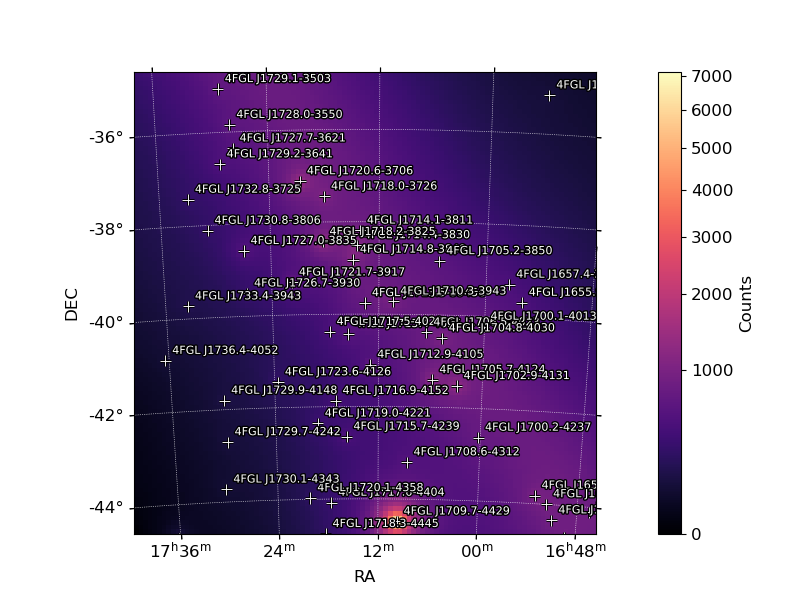

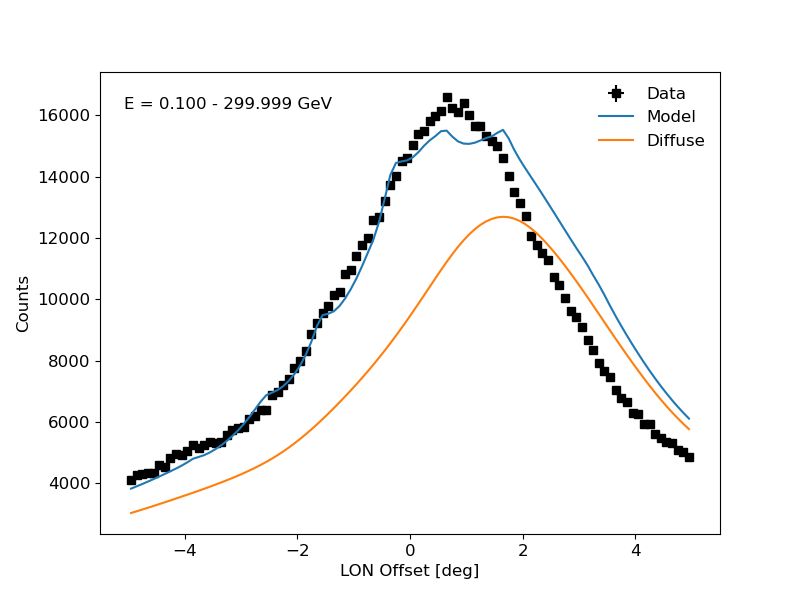

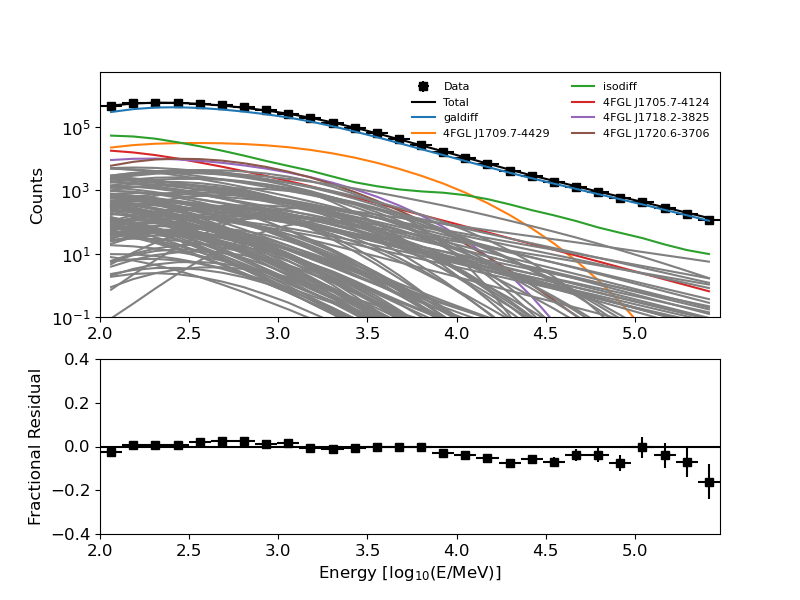

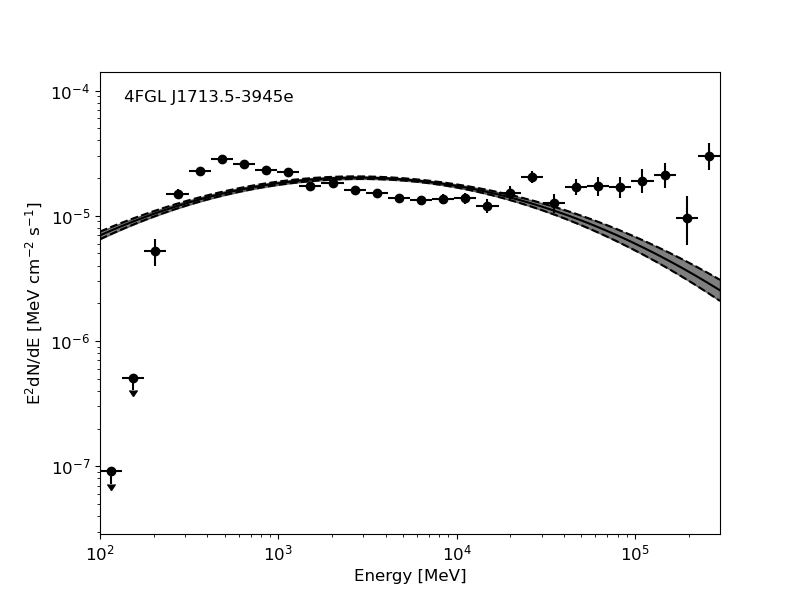

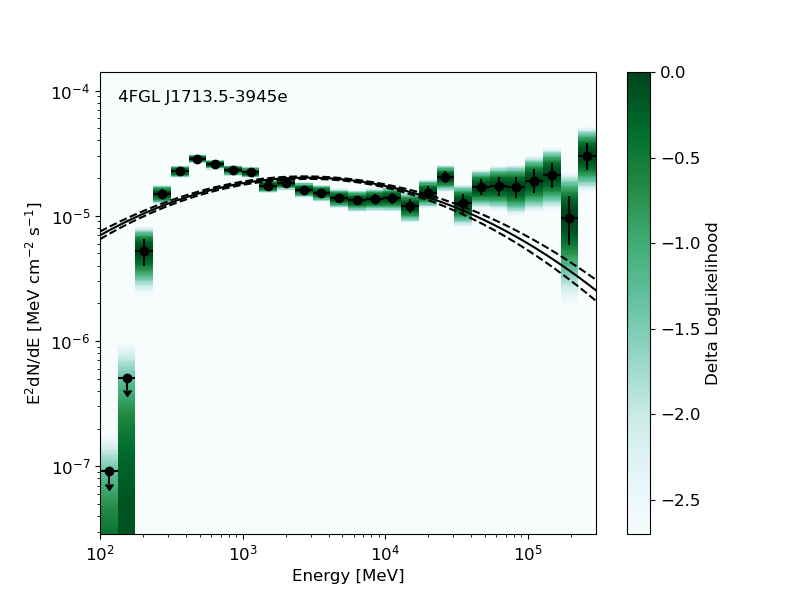

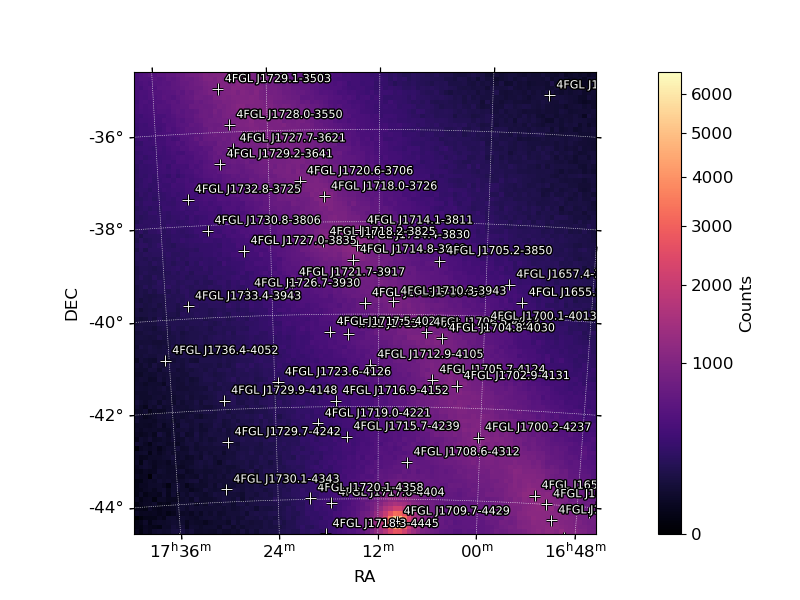

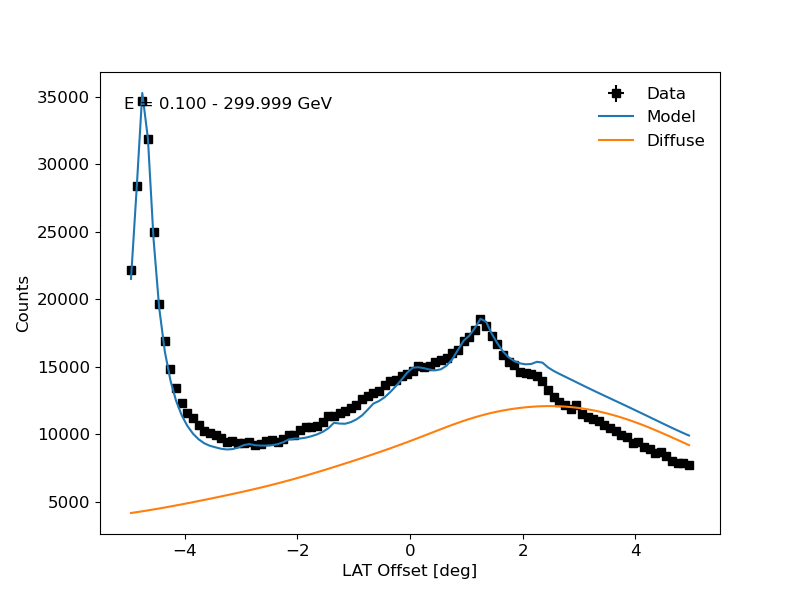

In [36]:
for png in pngs:
    my_image = Image(png)
    display(my_image)

### Reading in the results

Since the results are saved, you can load them back up at any point (you can also get to these within python).  Here we retrieve the analysis results from the output numpy file. 

In [37]:
c = np.load('data/fit0.npy', allow_pickle=True).flat[0]

The `sources` dictionary has an entry for each source in the model:

In [38]:
sorted(c['sources'].keys())

['4FGL J1634.6-4324',
 '4FGL J1636.9-4103',
 '4FGL J1637.8-3449',
 '4FGL J1638.5-4657',
 '4FGL J1639.8-4642',
 '4FGL J1640.6-4632',
 '4FGL J1641.0-4619',
 '4FGL J1644.5-4602',
 '4FGL J1645.1-3323',
 '4FGL J1645.1-4123c',
 '4FGL J1645.8-4533',
 '4FGL J1646.5-4406',
 '4FGL J1648.4-4611',
 '4FGL J1649.2-4513',
 '4FGL J1649.3-4441',
 '4FGL J1650.3-4600',
 '4FGL J1650.9-4420',
 '4FGL J1651.7-4359',
 '4FGL J1652.2-4516',
 '4FGL J1652.2-4633e',
 '4FGL J1653.2-4349',
 '4FGL J1654.0-3509',
 '4FGL J1655.9-3940',
 '4FGL J1656.3-3301',
 '4FGL J1657.4-3917c',
 '4FGL J1657.7-4520',
 '4FGL J1657.7-4656c',
 '4FGL J1658.3-4637c',
 '4FGL J1700.1-4013',
 '4FGL J1700.2-4237',
 '4FGL J1700.3-4557',
 '4FGL J1701.9-4625',
 '4FGL J1702.9-4131',
 '4FGL J1704.8-4030',
 '4FGL J1705.2-3850',
 '4FGL J1705.7-4124',
 '4FGL J1706.4-4609',
 '4FGL J1706.4-4649c',
 '4FGL J1706.5-4023',
 '4FGL J1706.8-4540',
 '4FGL J1708.6-4312',
 '4FGL J1709.7-4429',
 '4FGL J1710.3-3943',
 '4FGL J1711.1-4600c',
 '4FGL J1711.6-3407',
 '4

Let's take a look at the flux, spectral parameters, and TS.

In [39]:
c['sources'][source_name]['flux']

1.1419210970128591e-07

In [40]:
print(c['sources'][source_name]['param_names'][:4])
print(c['sources'][source_name]['param_values'][:4])

[b'norm' b'alpha' b'beta' b'Eb']
[2.22898898e-13 2.22345885e+00 9.65753442e-02 8.92238672e+03]


In [41]:
c['sources'][source_name]['ts']

4969.4923802390695

The SED is in there as well.  We can plot it.

In [42]:
E = np.array(c['sources'][source_name]['model_flux']['energies'])
dnde = np.array(c['sources'][source_name]['model_flux']['dnde'])
dnde_hi = np.array(c['sources'][source_name]['model_flux']['dnde_hi'])
dnde_lo = np.array(c['sources'][source_name]['model_flux']['dnde_lo'])

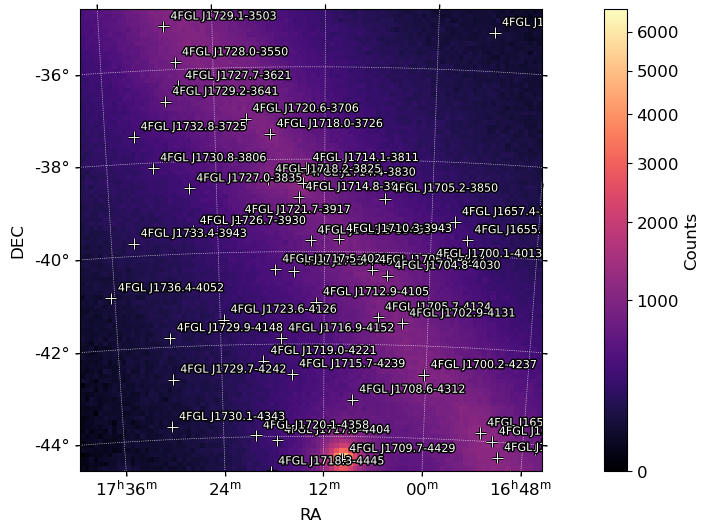

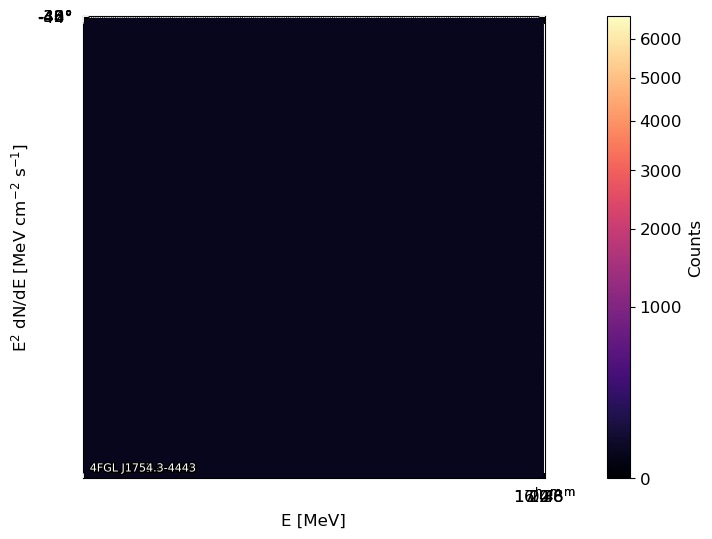

In [43]:
plt.loglog(E, (E**2)*dnde, 'k--')
plt.loglog(E, (E**2)*dnde_hi, 'k')
plt.loglog(E, (E**2)*dnde_lo, 'k')
plt.xlabel('E [MeV]')
plt.ylabel(r'E$^2$ dN/dE [MeV cm$^{-2}$ s$^{-1}$]')
plt.show()

If you want SED points, there's a function for that.  There are lots of options for this which you can set in the config file or from keyword arguments of the function itself.

In [44]:
sed = gta.sed(source_name,make_plots=True)

2023-10-11 17:48:09 INFO    GTAnalysis.sed(): Computing SED for 4FGL J1713.5-3945e
2023-10-11 17:49:11 INFO    GTAnalysis._make_sed(): Fitting SED
2023-10-11 17:49:11 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J1713.5-3945e    : ['alpha', 'beta']
2023-10-11 17:49:11 INFO    GTAnalysis.free_source(): Fixing parameters for galdiff               : ['Index']
2023-10-11 17:49:57 INFO    GTAnalysis.sed(): Finished SED
2023-10-11 17:50:14 INFO    GTAnalysis.sed(): Execution time: 124.63 s


You can save the state to the yaml file or you can just access it directly.  This is also the way to get at the dictionary for any individual source.

In [45]:
src = gta.roi[source_name]

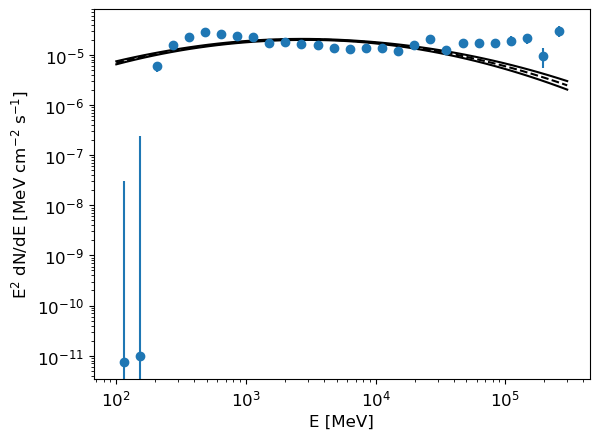

In [46]:
plt.loglog(E, (E**2)*dnde, 'k--')
plt.loglog(E, (E**2)*dnde_hi, 'k')
plt.loglog(E, (E**2)*dnde_lo, 'k')
plt.errorbar(np.array(sed['e_ctr']),
             sed['e2dnde'], 
             yerr=sed['e2dnde_err'], fmt ='o')
plt.xlabel('E [MeV]')
plt.ylabel(r'E$^{2}$ dN/dE [MeV cm$^{-2}$ s$^{-1}$]')
plt.show()

In [49]:
from astropy.table import Table
sed_tab = Table.read('data/4fgl_j1713.5-3945e_sed.fits')
sed_tab.write('data/4fgl_j1713.5-3945e_sed.ecsv',exclude_names=['norm_scan','dloglike_scan'],overwrite=True)

### Summary

There is a lot of other functionality and you should look through the docs for more details.  You can also inspect the GTAnalysis object for some of these (like TS Maps, extension tests, and using event types).  Following threads cover some of the more advanced functionality of fermipy:

* [IC443](ic443.ipynb) : Analysis to measure the angular extension of the SNR IC443.
* [Draco](draco.ipynb) : DM upper limit analysis of the Draco dwarf spheroidal galaxy.